In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# pip install catboost

### Import and constants

In [ ]:
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:,.3f}'.format
# import datetime
import os
from tqdm import tqdm
import pickle
from glob import glob
from itertools import product
import warnings

from scipy import stats
import statsmodels.api as sm

from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from sklearn.linear_model import ElasticNet, Ridge, Lasso, SGDRegressor
import lightgbm as lgb
import xgboost as xgb
from catboost import Pool, CatBoostRegressor

from sklearn.preprocessing import PowerTransformer, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import TransformedTargetRegressor

from sklearn.metrics import mean_absolute_error

from hyperopt import hp, fmin, tpe, rand, Trials, STATUS_OK


import holidays

In [ ]:
PATH_TO_DATA = '/content/drive/MyDrive/Colab Notebooks/taxi/'
# PATH_TO_DATA = '/mnt/e/GoogleDrive/Colab Notebooks/taxi/'
long = [-74.25559, -73.70001]
lat = [40.49612, 40.91553]
RANDOM_STATE = 30
START_DATE = '2015-03'
MAX_TRAIN_TIME = '2016-04'

### Helpers

In [ ]:
# def add_holidays(y):
#     holidays_NY = holidays.CountryHoliday('US', state='NY', years=[2015, 2016])
#     holidays_NY = pd.Series(holidays_NY.values(), index=holidays_NY.keys()).sort_index()
#     holidays_NY.index = pd.to_datetime(holidays_NY.index)
#     holidays_NY = holidays_NY.loc[y.index.min(): y.index.max()]
#     res = pd.DataFrame(np.zeros((y.shape[0], holidays_NY.nunique())),
#                  index=y.index, columns=holidays_NY.unique())
#     for index, holiday in holidays_NY.items():
#         res.loc[index.strftime('%Y-%m-%d'), holiday] = 1
#     return res

# def add_holidays(y):
#     holidays_NY = holidays.CountryHoliday('US', state='NY', years=[2015, 2016])
#     holidays_NY = pd.Series(holidays_NY.values(), index=holidays_NY.keys()).sort_index()
#     holidays_NY.index = pd.to_datetime(holidays_NY.index)
#     holidays_NY = holidays_NY.loc[y.index.min(): y.index.max()]
#     columns = list(holidays_NY.unique()) + [s+'_ba' for s in holidays_NY.unique()] + [s+'_af' for s in holidays_NY.unique()]
#     res = pd.DataFrame(np.zeros((y.shape[0], 3*holidays_NY.nunique())),
#                  index=y.index, columns=columns)
#     for index, holiday in holidays_NY.items():
#         res.loc[index.strftime('%Y-%m-%d'), holiday] = 1
#         before = (index - pd.Timedelta('1d')).strftime('%Y-%m-%d')
#         after = (index + pd.Timedelta('1d')).strftime('%Y-%m-%d')
#         res.loc[before, holiday+'_ba'] = 1
#         res.loc[after, holiday+'_af'] = 1
#     return res


# Праздничные дни запишем как нумерованные категории а не в виде dummies
def add_holidays(y):
    holidays_NY = holidays.CountryHoliday('US', state='NY', years=[2015, 2016])
    holidays_NY = pd.Series(holidays_NY.values(), index=holidays_NY.keys()).sort_index()
    holidays_NY.index = pd.to_datetime(holidays_NY.index)
    holidays_NY = holidays_NY.loc[y.index.min(): y.index.max()]
    res = pd.DataFrame(np.zeros((y.shape[0], 1)),
                 index=y.index, columns=['holiday'])
    for i, (index, holiday) in enumerate(holidays_NY.items()):
        res.loc[index.strftime('%Y-%m-%d'), 'holiday'] = 3 * i + 1
        before = (index - pd.Timedelta('1d')).strftime('%Y-%m-%d')
        after = (index + pd.Timedelta('1d')).strftime('%Y-%m-%d')
        res.loc[before] = 3 * i
        res.loc[after] = 3 * i + 2
        res = res.astype('int32')
    return res

In [ ]:
def load_model_data(model, v='norm', one_hot=False): # model 1..6
    X, y = [], []
    cat = 'cat_dummies' if one_hot else 'cat'
    for st in ['train', 'val', 'test']:
        x = pd.read_parquet(PATH_TO_DATA + f'regr_data/X_{st}_{v}.parquet')
        x['arima'] = pd.read_parquet(PATH_TO_DATA + f'regr_data/arima_{st}_{v}.parquet',
                                        columns=[f'arima_{model}']).values
        cat_features = pd.read_parquet(PATH_TO_DATA + f'regr_data/{cat}_{st}.parquet')
        y.append(pd.read_parquet(PATH_TO_DATA + f'regr_data/y_{st}.parquet',
                            columns=[f'y_{model}']).values.squeeze())
        X.append(pd.concat([cat_features, x], axis=1))
        
    return X[0], y[0], X[1], y[1], X[2], y[2]

In [ ]:
def load_model_data_new(model, v='norm', one_hot=False): # model 1..6
    X, y = [], []
    cat = 'cat_dummies' if one_hot else 'cat'
    for st in ['train', 'val', 'test']:
        x = pd.read_parquet(PATH_TO_DATA + f'regr_data/X_{st}_{v}_new.parquet')
        x['arima'] = pd.read_parquet(PATH_TO_DATA + f'regr_data/arima_{st}_{v}.parquet',
                                        columns=[f'arima_{model}']).values
        cat_features = pd.read_parquet(PATH_TO_DATA + f'regr_data/{cat}_{st}.parquet')
        y.append(pd.read_parquet(PATH_TO_DATA + f'regr_data/y_{st}.parquet',
                            columns=[f'y_{model}']).values.squeeze())
        X.append(pd.concat([cat_features, x], axis=1))
        
    return X[0], y[0], X[1], y[1], X[2], y[2]

### Load last week

In [ ]:
stacked_val = []
score_lgb_val = []
score_cb_val = []
for lag in range(1, 7):
    # load data
    X_train, y_train, X_val, y_val, X_test, y_test = load_model_data(lag, 'norm', False)
    # load models
    model_lgb = lgb.Booster(model_file=PATH_TO_DATA + f'models_week5/lgbm_{lag}')
    model_cb = CatBoostRegressor().load_model(PATH_TO_DATA + f'models_week5/catboost_{lag}')
    # y_pred_lgb = model_lgb.predict(X_train)
    # y_pred_cb = model_cb.predict(X_train)
    y_val_lgb = model_lgb.predict(X_val)
    y_val_cb = model_cb.predict(X_val)
    # y_test_lgb = model_lgb.predict(X_test)
    # y_test_cb = model_cb.predict(X_test)
    # stacked.append(pd.DataFrame({'lgb': y_pred_lgb, 'cb': y_pred_cb}))
    stacked_val.append(pd.DataFrame({'lgb': y_val_lgb, 'cb': y_val_cb}))
    # stacked_test.append(pd.DataFrame({'lgb': y_test_lgb, 'cb': y_test_cb}))

    score_lgb_val.append(mean_absolute_error(y_val, y_val_lgb))
    score_cb_val.append(mean_absolute_error(y_val, y_val_cb))
    # score_lgb_test.append(mean_absolute_error(y_test, y_test_lgb))
    # score_cb_test.append(mean_absolute_error(y_test, y_test_cb))

    print(f'MAE lgb_{lag}: val = {score_lgb_val[-1]}, MAE cb_{lag}: val = {score_cb_val[-1]}')
print(f'Q may: lgb = {sum(score_lgb_val)/6}, cb = {sum(score_cb_val)/6}')
# print(f'Q june: lgb = {sum(score_lgb_test)/6}, cb = {sum(score_cb_test)/6}')



MAE lgb_1: val = 13.718193881354914, MAE cb_1: val = 13.772460515066408
MAE lgb_2: val = 15.679534692838509, MAE cb_2: val = 15.733587625949276
MAE lgb_3: val = 16.722833973428198, MAE cb_3: val = 16.845813241222338
MAE lgb_4: val = 17.345579639134318, MAE cb_4: val = 17.71131091161503
MAE lgb_5: val = 17.517535210362418, MAE cb_5: val = 17.731386988274267
MAE lgb_6: val = 17.633782676214533, MAE cb_6: val = 17.641090041035554
Q may: lgb = 16.436243345555482, cb = 16.572608220527147


### Load raw  data

In [ ]:
with open(PATH_TO_DATA+'selected_regions.pkl', 'rb') as f:
    selected_regions = pickle.load(f)
zones = set(selected_regions)

In [ ]:
# Добавим географические зоны

def add_zone(df, s):
    # s - pickup or dropoff
    x = df[f'{s}_longitude'].values
    y = df[f'{s}_latitude'].values
    ret = stats.binned_statistic_2d(x, y, None, 'count', bins=50, range=[
                                    long, lat], expand_binnumbers=True)
    bn = ret.binnumber
    return (bn[0]-1)*50+bn[1]

# Убираем выбросы в длительности поездок, расстоянии и стоимости

def outliers(df):
    trip = df.trip_distance.quantile(.999)
    dur = df.duration.quantile(.999)
    price = df.total_amount.quantile(.999)
    df.loc[df.trip_distance > trip, 'trip_distance'] = trip
    df.loc[df.duration > dur, 'duration'] = dur
    df.loc[df.duration > dur, 'tpep_dropoff_datetime'] = (
        df.loc[df.duration > dur, 'tpep_pickup_datetime'] + pd.Timedelta(dur, 'min'))
    df.loc[df.total_amount > price, 'total_amount'] = price
    df.loc[df.total_amount <= 0, 'total_amount'] = df.loc[df.total_amount <= 0, 'trip_distance'] * 5


# Добавляем доли категориальных признаков

def add_fractions(df, col):
    # col - name of categorical column
    q = pd.crosstab([df.tpep_pickup_datetime, df.zone], df[col],
                    df.vendorid, aggfunc='count', normalize='index')
    q.rename(columns=lambda x: f'{col}_{x}', inplace=True)
    return q


# Соседние зоны. Создаем словарь.

def neibours(zone):
    r = zone // 50
    c = zone - r * 50
    res = [(r+i)*50+c+j for i in range(-1, 2)
           for j in range(-1, 2) if i != 0 or j != 0]
    res = [z for z in res if 0 < z < 2501]
    return res

neibours_dict = {zone: neibours(zone) for zone in zones}


def neibours_trips(g):
    # g - groupby datetime, select zone
    y = set(g) & zones
    res = pd.Series(
        {z: np.in1d(g.values, neibours_dict[z]).sum() for z in y}, dtype='int64').sort_index()
    return res


# Поездки в текущую зону (все или извне???)

def to_zone(df):
    res = df[df.dropoff_zone.isin(zones)].groupby(
        ['tpep_dropoff_datetime', 'dropoff_zone']).zone.count()
    return res

In [ ]:
%%time

files = glob('/mnt/e/python/taxi/raw/*.csv')
for file in tqdm(files):
    df = pd.read_csv(file, parse_dates=[1, 2], usecols=[
                     0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 18])
    df.columns = df.columns.str.lower()

    # Удаляем поездки с нулевой длительностью, нулевым количеством пассажиров
    # и нулевым расстоянием поездки по счётчику
    df = df[(df.tpep_pickup_datetime < df.tpep_dropoff_datetime)
            & (df.trip_distance > 0) & (df.passenger_count > 0)]
    # Удаляем поездки скоординатами начала за пределами Нью-Йорка
#     df = df[(long[0] <= df.pickup_longitude) & (df.pickup_longitude <= long[1]) &
#             (lat[0] <= df.pickup_latitude) & (df.pickup_latitude <= lat[1])]
    # Добавим длительность поездки
    df['duration'] = (df.tpep_dropoff_datetime -
                      df.tpep_pickup_datetime) / pd.Timedelta('1 min')

    # Исправляем неправдоподобно длинные поездки

    outliers(df)

    # Округляем время начала поездки до целого часа
    df['tpep_pickup_datetime'] = df.tpep_pickup_datetime.dt.floor(freq='H')
    df['tpep_dropoff_datetime'] = df.tpep_dropoff_datetime.dt.floor(freq='H')

    # Добавим географические зоны

    df['zone'] = add_zone(df, 'pickup')
    df['dropoff_zone'] = add_zone(df, 'dropoff')

    # Поездки из соседних зон
    trips_neibours = df.groupby(
        'tpep_pickup_datetime').zone.apply(neibours_trips)

    # Поездки в текущую зону
    trips_in = to_zone(df)

    # Оставляем только выбранные зоны
    df = df[df.zone.isin(zones)]

    #
    mi = pd.MultiIndex.from_product([sorted(df.tpep_pickup_datetime.unique()), sorted(
        df.zone.unique())], names=['tpep_pickup_datetime', 'zone'])
    temp = pd.DataFrame(index=mi)
    
    dfg = df.groupby(['tpep_pickup_datetime', 'zone']).agg(
        {'duration': 'mean', 'passenger_count': 'mean', 'trip_distance': 'mean',
         'total_amount': 'mean', 'dropoff_zone': 'count'})
    dfg = temp.join(dfg)
    dfg.rename(columns={'dropoff_zone': 'trips'}, inplace=True)
    dfg['trips_neibours'] = trips_neibours
    dfg['trips_in'] = trips_in

    # Добавим доли по типу тарифов, способу оплаты и провайдеру данных

    dfg = dfg.join([add_fractions(df, 'ratecodeid'), add_fractions(
        df, 'payment_type'), add_fractions(df, 'vendorid')])
    dfg = dfg.fillna(0)

    # Сохраняем в файл
    file = file.split('/')[-1].split('.')[0]
    dfg.to_parquet(PATH_TO_DATA + f'new_feature/{file}.parquet')

100%|██████████| 16/16 [53:09<00:00, 199.36s/it] 

CPU times: user 24min 46s, sys: 2min 33s, total: 27min 19s
Wall time: 53min 9s


### New feature

In [ ]:
# Загрузим новые данные
files = glob(PATH_TO_DATA + 'new_feature/*')
df = pd.DataFrame()
for file in tqdm(files):
    df = df.append(pd.read_parquet(file))

100%|██████████| 16/16 [00:23<00:00,  1.47s/it]


In [ ]:
df[:3]

duration  passenger_count  trip_distance  \
tpep_pickup_datetime zone                                             
2015-03-01           1075    13.030            1.574          3.611   
                     1076    16.229            1.718          4.227   
                     1077    13.150            1.882          3.527   

                           total_amount   trips  trips_neibours  trips_in  \
tpep_pickup_datetime zone                                                   
2015-03-01           1075        16.505  47.000         489.000    61.000   
                     1076        19.519 103.000       1,146.000   168.000   
                     1077        16.537  51.000       1,891.000    62.000   

                           ratecodeid_1  ratecodeid_2  ratecodeid_3  ...  \
tpep_pickup_datetime zone                                            ...   
2015-03-01           1075         1.000         0.000         0.000  ...   
                     1076         1.000         0.000         0.000  ...   
                     1077         1.000         0.000         0.000  ...   

                           ratecodeid_5  ratecodeid_6  ratecodeid_99  \
tpep_pickup_datetime zone                                              
2015-03-01           1075         0.000         0.000          0.000   
                     1076         0.000         0.000          0.000   
                     1077         0.000         0.000          0.000   

                           payment_type_1  payment_type_2  payment_type_3  \
tpep_pickup_datetime zone                                                   
2015-03-01           1075           0.617           0.362           0.021   
                     1076           0.738           0.252           0.010   
                     1077           0.647           0.353           0.000   

                           payment_type_4  payment_type_5  vendorid_1  \
tpep_pickup_datetime zone                                               
2015-03-01           1075           0.000           0.000       0.511   
                     1076           0.000           0.000       0.505   
                     1077           0.000           0.000       0.451   

                           vendorid_2  
tpep_pickup_datetime zone              
2015-03-01           1075       0.489  
                     1076       0.495  
                     1077       0.549  

[3 rows x 21 columns]

In [ ]:
# Посмотрим на корреляцию с колличеством поездок.
df.corrwith(df.trips).sort_values(key=lambda x: np.abs(x), ascending=False)

trips              1.000
trips_in           0.903
trips_neibours     0.857
payment_type_1     0.189
trip_distance     -0.148
ratecodeid_1       0.131
payment_type_2    -0.113
total_amount      -0.100
passenger_count    0.077
ratecodeid_2      -0.072
vendorid_2         0.065
payment_type_3    -0.041
ratecodeid_5      -0.036
vendorid_1         0.023
ratecodeid_4      -0.023
payment_type_4    -0.021
ratecodeid_3      -0.012
duration          -0.010
ratecodeid_6      -0.002
payment_type_5     0.001
ratecodeid_99     -0.001
dtype: float64

Заметная корреляция только в поездках из соседних зон и в выбранную зону.


In [ ]:
# отбросим признаки с кореляцией, близкой к нулю
drop_col = ['ratecodeid_3', 'ratecodeid_4', 'ratecodeid_5', 'ratecodeid_6',
            'ratecodeid_99', 'payment_type_3', 'payment_type_4', 
            'payment_type_5', 'vendorid_1', 'vendorid_2']
df = df.drop(drop_col, axis=1)
df.columns

Index(['duration', 'passenger_count', 'trip_distance', 'total_amount', 'trips',
       'trips_neibours', 'trips_in', 'ratecodeid_1', 'ratecodeid_2',
       'payment_type_1', 'payment_type_2'],
      dtype='object')

In [ ]:
# добавляем сумму поездок из соседних зон за 12 часов 
# и "приезды" в выбранную зону за 6, 12, 18, 24 часа
df_new = df.copy()
for zone in tqdm(zones):
    tdf = df_new.loc[(slice(None), zone), :]
    df_new.loc[(slice(None), zone), 'sum_12_neibours'] = tdf.trips_neibours.rolling(12).sum()
    for i in range(1, 5):
        df_new.loc[(slice(None), zone), f'sum_in_{i*6}H'] = tdf.trips_in.rolling(i*6).sum()

100%|██████████| 102/102 [00:54<00:00,  1.87it/s]


In [ ]:
columns_real_new = ['duration', 'passenger_count', 'trip_distance', 'total_amount',
              'trips', 'trips_neibours', 'trips_in', 'sum_12_neibours', 
              'sum_in_6H', 'sum_in_12H', 'sum_in_18H', 'sum_in_24H']


In [ ]:
# добавляем праздничные дни в виде категориальных данных
# также добавим день до и после. 

# add holidays
# df_new = pd.DataFrame(np.hstack([df_new.values, add_holidays(df_new.reset_index(-1))]),
#                       index=df_new.index, columns=df_new.columns)
df_new['holiday'] = add_holidays(df_new.reset_index(-1)).values

In [ ]:
df_new[-5:]

duration  passenger_count  ...  sum_in_24H  holiday
tpep_pickup_datetime zone                             ...                     
2015-03-01 00:00:00  1075    13.030            1.574  ...         nan        0
                     1076    16.229            1.718  ...         nan        0
                     1077    13.150            1.882  ...         nan        0
                     1125    15.859            1.808  ...         nan        0
                     1126    13.878            1.808  ...         nan        0
...                             ...              ...  ...         ...      ...
2016-06-30 23:00:00  2068    42.735            1.748  ...   1,115.000        0
                     2069    36.181            1.553  ...      63.000        0
                     2118    41.435            1.809  ...   1,499.000        0
                     2119    39.652            1.941  ...     389.000        0
                     2168     0.000            0.000  ...     497.000        0

[1194624 rows x 17 columns]

In [ ]:
# Добавим новые признаки в файлы из прошлой недели, сделаем стандартизацию новых вещественных признаков и запишим в новые файлы

stages = ['train', 'val', 'test']
scaler = StandardScaler()
for st in stages:
    X = pd.read_parquet(PATH_TO_DATA + f'regr_data/X_{st}_norm.parquet')
    zone = pd.read_parquet(PATH_TO_DATA + f'regr_data/cat_{st}.parquet').zone
    X = X.set_index([X.index, zone])
    X = X.merge(df_new, how='left', left_index=True, right_index=True)
    X = X.reset_index(-1, drop=True)
    if st == 'train':
        X[columns_real_new] = scaler.fit_transform(X[columns_real_new])
    else:
        X[columns_real_new] = scaler.transform(X[columns_real_new])
    X.to_parquet(PATH_TO_DATA + f'regr_data/X_{st}_norm_new.parquet')

### Models

Функционал ошибки = средней абсолютной ошибке по всем предсказаниям и всем моделям. Одинаковый размер моделей позволяет посчитать ошибку отдельно для каждой модели и усреднить ее.

\begin{equation}
Q_{may} = \frac{1}{R*739*6}\sum_{i=1}^6\sum_{r=1}^R\sum_{T=2016.04.3023:00}^{2016.05.3117:00}|y_{T|T+i}^r-y_{T|T+i}^r| = \frac{1}6\sum_{i=1}^6\frac{1}{R*739}\sum_{r=1}^R\sum_{T=2016.04.3023:00}^{2016.05.3117:00}|y_{T|T+i}^r-y_{T|T+i}^r|
\end{equation}

\begin{equation}
Q_{may} = \frac{1}6\sum_{i=1}^6MAE_i
 \end{equation}

Поиск гиперпараметров будем вести с помощью библиотеки hyperopt

#### LightGBM

In [ ]:
def objective_lgbm(params):
    """
    Валидация с текущими гиперпараметрами

    :params: гиперпараметры
    :pipeline: модель
    :X_train, X_val: матрица признаков 
    :y_train, y_val: вектор значений объектов
    :return: 'mae' on X_val, y_val
    """ 

    # задаём модели требуемые параметры
    num_round = 100000
    param = {'objective':'regression', 'lambda_l2': 0, 'lambda_l1': 0, 
             'max_bin_by_feature': ([32]*6 + [255]*45 + [1024]),
             'verbose': 0, 'random_state': 99}
    param['metric'] = ['l1']
    param.update(params)
    param['num_leaves'] = int(param['num_leaves'])
            
    # обучаем модель и считаем среднюю абсолютною ошибку на данных за май
    model = lgb.train(param, dtrain, num_round, valid_sets=[dval],
                    early_stopping_rounds=10, verbose_eval=5000)
    
    score = mean_absolute_error(y_val, model.predict(X_val))
    
    try:
        best = score < trials.best_trial['result']['loss']
    except:
        best = True
    if best: model.save_model(PATH_TO_DATA + f'models/lgbm_{lag}', num_iteration=model.best_iteration)

    # возвращаем результаты, которые записываются в Trials()
    return   {'loss': score, 'params': params, 'status': STATUS_OK}

In [ ]:
# 

warnings.filterwarnings('ignore')

search_space = {'num_leaves': hp.quniform('num_leaves', low=700, high=750, q=50),
                'max_depth': hp.choice('max_depth', [-1]), 
                # 'max_bin': hp.choice('max_bin', [255]),   
                'learning_rate': hp.uniform('learning_rate', low=0.02, high=0.03)
                }

trials_lgbm = []

for lag in tqdm(range(1, 7)):
    # load data
    X_train, y_train, X_val, y_val, _, _ = load_model_data_new(lag, 'norm', False)
    # make Dataset
    columns_cat=['zone', 'holiday']
    dtrain = lgb.Dataset(X_train, label=y_train, 
                         categorical_feature=columns_cat, free_raw_data=False)
    dval = lgb.Dataset(X_val, label=y_val, 
                       reference=dtrain, categorical_feature=columns_cat)
    # 
    trials = Trials()
    best = fmin( 
            # функция для оптимизации  
                fn=objective_lgbm,
            # пространство поиска гиперпараметров  
                space=search_space,
            # алгоритм поиска
                algo=rand.suggest,
                # algo=tpe.suggest,
            # число итераций 
            # (можно ещё указать и время поиска) 
                max_evals=2,
            # куда сохранять историю поиска
                trials=trials,
            # random state
                rstate=np.random.RandomState(99),
            # progressbar
                show_progressbar=False
                )
    trials_lgbm.append(trials)
    print(f"\t\tMAE = {trials.best_trial['result']['loss']}")
print(f"\nQmay = {sum([trials.best_trial['result']['loss'] for trials in trials_lgbm]) / 6}")

warnings.filterwarnings('default')

  0%|          | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[1570]	valid_0's l1: 13.1718
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[1934]	valid_0's l1: 13.1581


 17%|█▋        | 1/6 [33:53<2:49:26, 2033.32s/it]

		MAE = 13.16383341920675
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[1498]	valid_0's l1: 15.1621
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[1467]	valid_0's l1: 15.1623


 33%|███▎      | 2/6 [1:01:25<2:07:56, 1919.01s/it]

		MAE = 15.19723480764621
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[1240]	valid_0's l1: 16.3266
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[1531]	valid_0's l1: 16.261


 50%|█████     | 3/6 [1:26:06<1:29:23, 1787.72s/it]

		MAE = 16.286695334583207
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[1568]	valid_0's l1: 16.8665
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[1869]	valid_0's l1: 16.8642


 67%|██████▋   | 4/6 [1:54:30<58:44, 1762.43s/it]  

		MAE = 16.829222157356583
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[914]	valid_0's l1: 17.3685
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[1042]	valid_0's l1: 17.2836


 83%|████████▎ | 5/6 [2:13:03<26:07, 1567.75s/it]

		MAE = 17.285621117753458
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[1695]	valid_0's l1: 17.3045
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[1441]	valid_0's l1: 17.3568


100%|██████████| 6/6 [2:39:05<00:00, 1590.98s/it]

		MAE = 17.30698729524876

Qmay = 16.01159902196583


#### CatBoost

In [ ]:
def objective_cb(params):
    """
    Валидация с текущими гиперпараметрами

    :params: гиперпараметры
    :pipeline: модель
    :X_train, X_val: матрица признаков 
    :y_train, y_val: вектор значений объектов
    :return: 'mae' on X_val, y_val
    """ 

    # задаём модели требуемые параметры
    param = {'iterations': 100000, 'one_hot_max_size': 102, 'border_count': 255,
             'eval_metric': 'MAE', 'random_seed': 99, 'has_time': True,
             'verbose': 5000, 'task_type': 'GPU',
             'od_type': 'Iter', 'od_wait': 40, 
             'per_float_feature_quantization': '51:border_count=1024'
            }
    param.update(params)
            
    # обучаем модель и считаем среднюю абсолютною ошибку на данных за май
    print('\n')
    model = CatBoostRegressor(**param)
    model.fit(train_pool, eval_set=validate_pool)
    
    score = mean_absolute_error(y_val, model.predict(X_val))

    try:
        best = score < trials.best_trial['result']['loss']
    except:
        best = True
    if best: model.save_model(PATH_TO_DATA + f'models/catboost_{lag}')

    # возвращаем результаты, которые записываются в Trials()
    return   {'loss': score, 'params': params, 'status': STATUS_OK}

In [ ]:
warnings.filterwarnings('ignore')

search_space = {'subsample': hp.choice('subsample', [0.66]),
                'max_depth': hp.choice('max_depth', [10]), 
                'l2_leaf_reg': hp.choice('l2_leaf_reg', [1]),
                'bootstrap_type': hp.choice('bootstrap_type', ['Bernoulli']), 
                #'learning_rate': hp.choice('learning_rate', [0.03]) #hp.loguniform('learning_rate', low=np.log(0.005), high=np.log(0.1))
                }

trials_cb = []

for lag in tqdm(range(1, 7)):
    # load data
    X_train, y_train, X_val, y_val, _, _ = load_model_data_new(lag, 'norm', False)
    # temp
    # X_train.drop(['ratecodeid_1', 'ratecodeid_2', 'payment_type_1', 'payment_type_2'], axis=1, inplace=True)
    # X_val.drop(['ratecodeid_1', 'ratecodeid_2', 'payment_type_1', 'payment_type_2'], axis=1, inplace=True)

    # make Dataset
    cat_features_indices = [4, 5, 50]
    train_pool = Pool(X_train, y_train, cat_features=cat_features_indices)
    validate_pool = Pool(X_val, y_val, cat_features=cat_features_indices)
    # 
    trials = Trials()
    best = fmin( 
            # функция для оптимизации  
                fn=objective_cb,
            # пространство поиска гиперпараметров  
                space=search_space,
            # алгоритм поиска
                # algo=tpe.suggest,
                algo=rand.suggest,
            # число итераций 
            # (можно ещё указать и время поиска) 
                max_evals=1,
            # куда сохранять историю поиска
                trials=trials,
            # random state
                rstate=np.random.RandomState(99),
            # progressbar
                show_progressbar=True
                )
    trials_cb.append(trials)
    print(f"\t\tMAE = {trials.best_trial['result']['loss']}")
print(f"\nQmay = {sum([trials.best_trial['result']['loss'] for trials in trials_cb]) / 6}")

warnings.filterwarnings('default')

  0%|          | 0/6 [00:00<?, ?it/s]


  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]0:	learn: 172.8668900	test: 169.2129666	best: 169.2129666 (0)	total: 49.7ms	remaining: 1h 22m 47s
5000:	learn: 10.8115715	test: 13.3095217	best: 13.3093020 (4998)	total: 2m 34s	remaining: 48m 54s
10000:	learn: 9.0626764	test: 12.9737656	best: 12.9737656 (10000)	total: 5m 13s	remaining: 46m 57s
bestTest = 12.86348222
bestIteration = 13920
Shrink model to first 13921 iterations.

100%|██████████| 1/1 [07:29<00:00, 449.29s/it, best loss: 12.86348661853988]

 17%|█▋        | 1/6 [07:32<37:40, 452.03s/it]


		MAE = 12.86348661853988

  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]0:	learn: 172.9217978	test: 169.1810210	best: 169.1810210 (0)	total: 50.2ms	remaining: 1h 23m 37s
5000:	learn: 11.6228819	test: 15.0633690	best: 15.0633690 (5000)	total: 2m 35s	remaining: 49m 23s
10000:	learn: 9.6400952	test: 14.6252670	best: 14.6252007 (9996)	total: 5m 14s	remaining: 47m 13s
bestTest = 14.48282158
bestIteration = 13992
Shrink model to first 13993 iterations.

100%|██████████| 1/1 [07:36<00:00, 456.42s/it, best loss: 14.482817118953708]

 33%|███▎      | 2/6 [15:11<30:17, 454.37s/it]


		MAE = 14.482817118953708

  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]0:	learn: 172.9579130	test: 169.1383295	best: 169.1383295 (0)	total: 49.3ms	remaining: 1h 22m 9s
5000:	learn: 11.8174318	test: 16.1780725	best: 16.1780725 (5000)	total: 2m 36s	remaining: 49m 23s
10000:	learn: 9.8258465	test: 15.7541491	best: 15.7541491 (10000)	total: 5m 14s	remaining: 47m 10s
bestTest = 15.64914332
bestIteration = 12794
Shrink model to first 12795 iterations.

100%|██████████| 1/1 [06:56<00:00, 416.58s/it, best loss: 15.649132517887269]

 50%|█████     | 3/6 [22:13<22:13, 444.48s/it]


		MAE = 15.649132517887269

  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]0:	learn: 172.9787202	test: 169.1214280	best: 169.1214280 (0)	total: 49.2ms	remaining: 1h 21m 58s
5000:	learn: 11.9872804	test: 16.7197458	best: 16.7195584 (4997)	total: 2m 35s	remaining: 49m 22s
10000:	learn: 9.9802033	test: 16.2951027	best: 16.2951027 (10000)	total: 5m 14s	remaining: 47m 8s
bestTest = 16.21438119
bestIteration = 11994
Shrink model to first 11995 iterations.

100%|██████████| 1/1 [06:29<00:00, 389.61s/it, best loss: 16.214392824138667]

 67%|██████▋   | 4/6 [28:46<14:18, 429.12s/it]


		MAE = 16.214392824138667

  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]0:	learn: 173.0002209	test: 169.1362201	best: 169.1362201 (0)	total: 49ms	remaining: 1h 21m 44s
5000:	learn: 12.0806731	test: 17.1064734	best: 17.1064734 (5000)	total: 2m 35s	remaining: 49m 20s
bestTest = 16.92128671
bestIteration = 6822
Shrink model to first 6823 iterations.

100%|██████████| 1/1 [03:41<00:00, 221.84s/it, best loss: 16.921300486763236]

 83%|████████▎ | 5/6 [32:31<06:07, 367.82s/it]


		MAE = 16.921300486763236

  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]0:	learn: 173.0254206	test: 169.1609090	best: 169.1609090 (0)	total: 51.9ms	remaining: 1h 26m 26s
5000:	learn: 12.1282622	test: 17.1727361	best: 17.1727361 (5000)	total: 2m 35s	remaining: 49m 19s
bestTest = 17.00051905
bestIteration = 6829
Shrink model to first 6830 iterations.

100%|██████████| 1/1 [03:43<00:00, 223.01s/it, best loss: 17.00050797361113]

100%|██████████| 6/6 [36:17<00:00, 362.86s/it]


		MAE = 17.00050797361113

Qmay = 15.521939589982315


Посмотрим на значимость признаков в модели

In [ ]:
model = CatBoostRegressor()
model.load_model(PATH_TO_DATA + f'models/catboost_1')

In [ ]:
pd.DataFrame({'feature_importance': model.get_feature_importance(train_pool), 
              'feature_names': X_val.columns}).sort_values(by=['feature_importance'], 
                                                           ascending=False)

,feature_importance,feature_names
51,43.613,arima
38,16.410,trips
16,2.896,W_cos_1
6,2.260,D_sin_1
22,2.191,hourAgo_1
40,2.033,trips_in
28,1.945,dayAgo_1
9,1.578,D_cos_2
39,1.500,trips_neibours
5,1.354,zone


Значимость признаков соответствует ожиданию. Малозначимые можно убрать без существенного ухудшения модели. Но все же с ними модель немного точнее. 

### Stacked model

In [ ]:
# сохраним предсказания моделей на май и июнь
stacked_val, stacked_test = [], []
score_lgb_val, score_lgb_test = [], []
score_cb_val, score_cb_test = [], []
for lag in range(1, 7):
    # load data
    X_train, y_train, X_val, y_val, X_test, y_test = load_model_data_new(lag, 'norm', False)
    # load models
    model_lgb = lgb.Booster(model_file=PATH_TO_DATA + f'models/lgbm_{lag}')
    model_cb = CatBoostRegressor().load_model(PATH_TO_DATA + f'models/catboost_{lag}')
    # предсказания
    y_val_lgb = model_lgb.predict(X_val)
    y_val_cb = model_cb.predict(X_val)
    y_test_lgb = model_lgb.predict(X_test)
    y_test_cb = model_cb.predict(X_test)
    
    stacked_val.append(pd.DataFrame({'lgb': y_val_lgb, 'cb': y_val_cb}))
    stacked_test.append(pd.DataFrame({'lgb': y_test_lgb, 'cb': y_test_cb}))

    score_lgb_val.append(mean_absolute_error(y_val, y_val_lgb))
    score_cb_val.append(mean_absolute_error(y_val, y_val_cb))
    score_lgb_test.append(mean_absolute_error(y_test, y_test_lgb))
    score_cb_test.append(mean_absolute_error(y_test, y_test_cb))

    print(f'MAE lgb_{lag}: val = {score_lgb_val[-1]}, test = {score_lgb_test[-1]}')
    print(f'MAE cb_{lag}: val = {score_cb_val[-1]}, test = {score_cb_test[-1]}')
print(f'Q may: lgb = {sum(score_lgb_val)/6}, cb = {sum(score_cb_val)/6}')
print(f'Q june: lgb = {sum(score_lgb_test)/6}, cb = {sum(score_cb_test)/6}')


MAE lgb_1: val = 13.16383341920675, test = 13.213453888890205
MAE cb_1: val = 12.86348661853988, test = 12.899172515250301
MAE lgb_2: val = 15.19723480764621, test = 14.585202922888142
MAE cb_2: val = 14.482817118953708, test = 14.332094509656024
MAE lgb_3: val = 16.286695334583207, test = 15.287045773486305
MAE cb_3: val = 15.649132517887269, test = 15.048166530447627
MAE lgb_4: val = 16.829222157356583, test = 15.680641798819439
MAE cb_4: val = 16.214392824138667, test = 15.38813892511716
MAE lgb_5: val = 17.285621117753458, test = 16.022352314468307
MAE cb_5: val = 16.921300486763236, test = 15.832474776229779
MAE lgb_6: val = 17.30698729524876, test = 15.990094879132682
MAE cb_6: val = 17.00050797361113, test = 15.914900958471252
Q may: lgb = 16.01159902196583, cb = 15.521939589982315
Q june: lgb = 15.129798596280848, cb = 14.902491369195355


In [ ]:
with open(PATH_TO_DATA + 'models/stacked.pickle', 'wb') as f:
    pickle.dump(stacked, f)
with open(PATH_TO_DATA + 'models/stacked_val.pickle', 'wb') as f:
    pickle.dump(stacked_val, f)
with open(PATH_TO_DATA + 'models/stacked_test.pickle', 'wb') as f:
    pickle.dump(stacked_test, f)

В предсказаниях имеются отрицательные значения, которые невозможны и мы можем их обнулить. 
В качестве конечного предсказания возьмем средне арифметическое двух моделей.

In [ ]:
# with open(PATH_TO_DATA + 'models/stacked.pickle', 'rb') as f:
#     stacked = pickle.load(f)
# with open(PATH_TO_DATA + 'models/stacked_val.pickle', 'rb') as f:
#     stacked_val = pickle.load(f)
# with open(PATH_TO_DATA + 'models/stacked_test.pickle', 'rb') as f:
#     stacked_test = pickle.load(f)

read old kaggle file for 'id' column
kaggle = pd.read_csv(PATH_TO_DATA + 'kaggle_yt.csv')

val, test = [], []
for lag in range(6):
    # load data
    _, _, _, y_val, X_test, y_test = load_model_data_new(lag+1, 'norm', False)
    pred_val = stacked_val[lag].mean(axis=1)
    pred_test = stacked_test[lag].mean(axis=1)
    pred_val.where(pred_val>=0, 0, inplace=True)
    pred_test.where(pred_test>=0, 0, inplace=True)

    err_val = mean_absolute_error(y_val, pred_val)
    err_test = mean_absolute_error(y_test, pred_test)
    val.append(err_val)
    test.append(err_test)

    # save data for kaggle
    X_test['y'] = pred_test.values
    X_test.sort_values(['zone', 'tpep_pickup_datetime'], inplace=True)
    kaggle.loc[lag::6, 'y'] = X_test['y'].values


print(f'Q may = {sum(val)/6}')
print(f'Q june = {sum(test)/6}')

Q may = 15.505053814389846
Q june = 14.784277841757373


### **"Переобучите итоговые модели на данных до мая 2016 включительно"**


In [ ]:
stacked_test = []
score_lgb_test = []
score_cb_test = []
n_cb = [13920, 13992, 12794, 11994, 6822, 6829]
for lag in range(1, 7):
    # load data
    X_train, y_train, X_val, y_val, X_test, y_test = load_model_data_new(lag, 'norm', False)
    cat_features_indices = [4, 5, 50]
    columns_cat=['zone', 'holiday']
    X = X_train.append(X_val)
    y = np.hstack([y_train, y_val])
    train_pool = Pool(X, y, cat_features=cat_features_indices)
    # load models
    model_lgb = lgb.Booster(model_file=PATH_TO_DATA + f'models/lgbm_{lag}')
    model_cb = CatBoostRegressor().load_model(PATH_TO_DATA + f'models/catboost_{lag}')

    # refit LightGBM
    model_lgb_refit = model_lgb.refit(X_val, y_val, columns_cat)

    # refit CatBoost
    param = model_cb.get_params()
    del model_cb
    
    model_cb_refit = CatBoostRegressor(**param)
    model_cb_refit.set_params(iterations=n_cb[lag-1])
    model_cb_refit.fit(train_pool)
    # predictions
    y_test_lgb = model_lgb_refit.predict(X_test)
    y_test_cb = model_cb_refit.predict(X_test)
    
    stacked_test.append(pd.DataFrame({'lgb': y_test_lgb, 'cb': y_test_cb}))
    # 
    score_lgb_test.append(mean_absolute_error(y_test, y_test_lgb))
    score_cb_test.append(mean_absolute_error(y_test, y_test_cb))

    print(f'MAE lgb_{lag}: test = {score_lgb_test[-1]}, cb_{lag}: test = {score_cb_test[-1]}')
    print(f'MAE cb_{lag}: test = {score_cb_test[-1]}') # забыл убрать

print(f'Q june: lgb = {sum(score_lgb_test)/6}, cb = {sum(score_cb_test)/6}')

0:	learn: 172.5275387	total: 49.5ms	remaining: 11m 28s
5000:	learn: 10.9105639	total: 2m 32s	remaining: 4m 31s
10000:	learn: 9.2174712	total: 5m 7s	remaining: 2m
13919:	learn: 8.2826379	total: 7m 9s	remaining: 0us
MAE lgb_1: test = 13.150377580519281, cb_1: test = 12.721133221473213
MAE cb_1: test = 12.721133221473213
0:	learn: 172.5768437	total: 49.6ms	remaining: 11m 34s
5000:	learn: 11.7254663	total: 2m 32s	remaining: 4m 33s
10000:	learn: 9.7979567	total: 5m 6s	remaining: 2m 2s
13991:	learn: 8.7460729	total: 7m 11s	remaining: 0us
MAE lgb_2: test = 14.482887437533916, cb_2: test = 14.038965522803682
MAE cb_2: test = 14.038965522803682
0:	learn: 172.6068281	total: 50.3ms	remaining: 10m 43s
5000:	learn: 11.9241704	total: 2m 32s	remaining: 3m 57s
10000:	learn: 9.9878614	total: 5m 6s	remaining: 1m 25s
12793:	learn: 9.2192083	total: 6m 33s	remaining: 0us
MAE lgb_3: test = 15.13051114880277, cb_3: test = 14.626948851873436
MAE cb_3: test = 14.626948851873436
0:	learn: 172.6280792	total: 49.

In [ ]:
kaggle = pd.read_csv(PATH_TO_DATA + 'kaggle_yt.csv')

val, test = [], []
for lag in range(6):
    # load data
    _, _, _, y_val, X_test, y_test = load_model_data_new(lag+1, 'norm', False)
    # усредняем
    pred_test = stacked_test[lag].mean(axis=1)
    # обнуляем отрицательные значения
    pred_test.where(pred_test>=0, 0, inplace=True)

    err_test = mean_absolute_error(y_test, pred_test)
    test.append(err_test)

    # save data for kaggle
    X_test['y'] = pred_test.values
    X_test.sort_values(['zone', 'tpep_pickup_datetime'], inplace=True)
    kaggle.loc[lag::6, 'y'] = X_test['y'].values


print(f'Q june = {sum(test)/6}')

Q june = 14.478979373038039


In [ ]:
kaggle.to_csv(PATH_TO_DATA + 'kaggle_yt_week6_refit.csv', index=False)

### Final

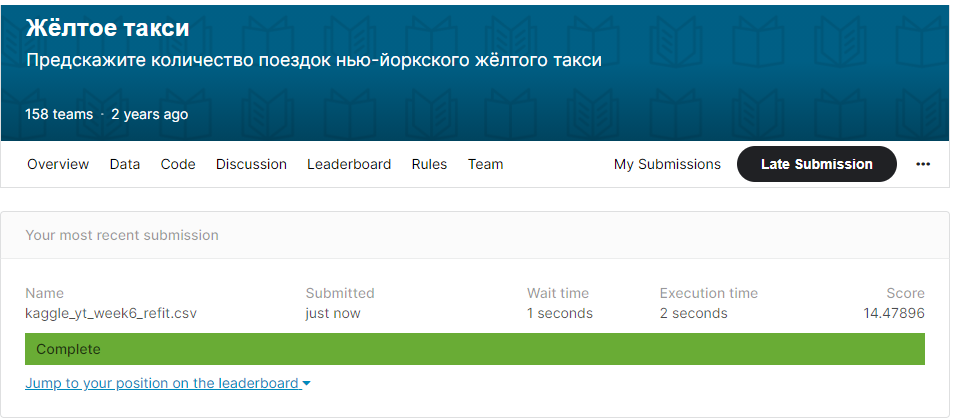